In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
import quandl
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
from functions.evolutionaryalgo import quadratic_loss_function
from simfinmodel import *
import statsmodels.api as sm
from matplotlib import style
import json
from collections import OrderedDict
import seaborn as sns
import scipy.stats as stats
import scipy

In [2]:
style.available

['seaborn-darkgrid',
 'Solarize_Light2',
 'seaborn-notebook',
 'classic',
 'seaborn-ticks',
 'grayscale',
 'bmh',
 'seaborn-talk',
 'dark_background',
 'ggplot',
 'fivethirtyeight',
 '_classic_test',
 'seaborn-colorblind',
 'seaborn-deep',
 'seaborn-whitegrid',
 'seaborn-bright',
 'seaborn-poster',
 'seaborn-muted',
 'seaborn-paper',
 'seaborn-white',
 'fast',
 'seaborn-pastel',
 'seaborn-dark',
 'tableau-colorblind10',
 'seaborn',
 'seaborn-dark-palette']

In [3]:
style.use('ggplot')

In [4]:
empirical_moments = np.array([ -9.56201354e-03,  -9.55051841e-02,  -5.52010512e-02,
         3.35217232e-01,   1.24673150e+01,   3.46352635e-01,
         2.72135459e-01,   1.88193342e-01,   1.75876698e-01,
        -3.39594806e+00])

W = np.array([[  3.19813864e+05,  -1.23647688e+04,  -7.75253249e+02,
         -9.96776357e+02,  -3.46059595e+01,  -8.45442951e+01,
          1.30642711e+02,   8.21228832e+02,  -7.53254275e+02,
          4.01244860e-01],
       [ -1.23647688e+04,   3.09643983e+03,  -9.12387428e+02,
          7.15088809e+02,   4.00622557e+00,  -2.07088870e+02,
          2.23333826e+02,   2.47454265e+01,  -7.69804083e+01,
         -9.32556575e-01],
       [ -7.75253249e+02,  -9.12387428e+02,   2.45450034e+03,
         -5.66285993e+02,   2.50019644e+00,   7.52973406e+01,
         -6.53708966e+01,   1.49542112e+01,  -3.22682344e+01,
         -8.15971301e-02],
       [ -9.96776357e+02,   7.15088809e+02,  -5.66285993e+02,
          6.03184170e+02,  -6.93622662e+00,  -3.92832732e+01,
          5.68213213e+01,  -2.51354209e+01,  -5.92040756e-01,
         -1.47482933e-01],
       [ -3.46059595e+01,   4.00622557e+00,   2.50019644e+00,
         -6.93622662e+00,   2.12483995e-01,  -1.07699983e+00,
          7.97173695e-01,   6.64963370e-01,  -4.66126569e-01,
          1.13807341e-03],
       [ -8.45442951e+01,  -2.07088870e+02,   7.52973406e+01,
         -3.92832732e+01,  -1.07699983e+00,   1.23523697e+04,
         -1.37167420e+04,  -1.80945248e+03,   5.03115269e+03,
         -5.47676063e-01],
       [  1.30642711e+02,   2.23333826e+02,  -6.53708966e+01,
          5.68213213e+01,   7.97173695e-01,  -1.37167420e+04,
          1.68349608e+04,  -6.34482252e+01,  -5.39173033e+03,
          4.87711333e-01],
       [  8.21228832e+02,   2.47454265e+01,   1.49542112e+01,
         -2.51354209e+01,   6.64963370e-01,  -1.80945248e+03,
         -6.34482252e+01,   5.75725915e+03,  -4.01464585e+03,
         -3.56169092e-01],
       [ -7.53254275e+02,  -7.69804083e+01,  -3.22682344e+01,
         -5.92040756e-01,  -4.66126569e-01,   5.03115269e+03,
         -5.39173033e+03,  -4.01464585e+03,   5.75734730e+03,
          5.83832248e-01],
       [  4.01244860e-01,  -9.32556575e-01,  -8.15971301e-02,
         -1.47482933e-01,   1.13807341e-03,  -5.47676063e-01,
          4.87711333e-01,  -3.56169092e-01,   5.83832248e-01,
          3.93494501e-01]])

# Compare estimated models

In [5]:
NRUNS = 10

In [122]:
params = {"spread_max": 0.004087, "fundamental_value": 166, 
          "trader_sample_size": 10, "n_traders": 1000, 
          "ticks": 2500, "std_fundamental": 0.0530163128919286, 
          "std_noise": 0.10696588473846724, "w_mean_reversion": 0.01, 
          "w_fundamentalists": 15.5, "w_momentum": 200.055017297045524, 
          "max_order_expiration_ticks": 30, "std_vol": 7, "w_random": 25.28414619497076, 
          "horizon_max": 20}

params_nmr = {"spread_max": 0.004087, "fundamental_value": 166, "trader_sample_size": 12, 
              "n_traders": 1000, "ticks": 2500, "std_fundamental": 0.0530163128919286, 
              "w_momentum": 44.39324905940566, "std_noise": 0.058586983268277604, 
              "w_fundamentalists": 9.83443104288905, 
              "std_vol": 8, "max_order_expiration_ticks": 30, "w_random": 34.784291415450156, 
              "horizon_max": 24, "w_mean_reversion": 0.0}

# Run model with mean-reversion

In [123]:
traders = []
obs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects(params, seed)
    traders, orderbook = sim_fin_model(traders, orderbook, params, seed)
    traders.append(traders)
    obs.append(orderbook)

In [124]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(obs)

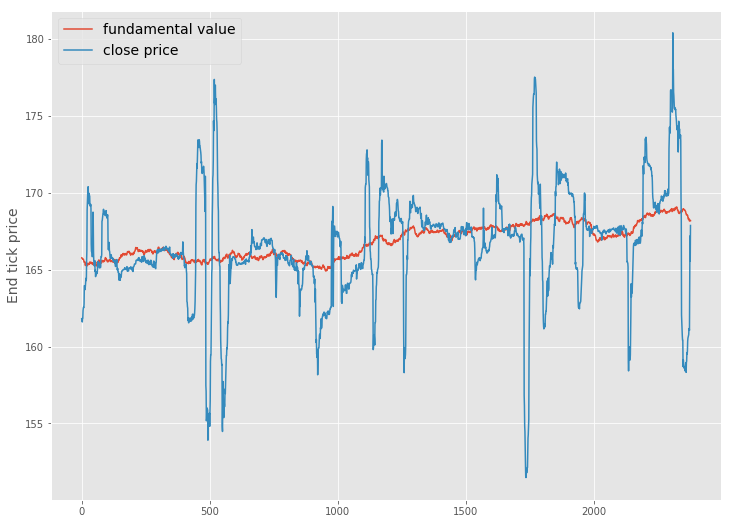

In [131]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,9))

ax1.plot(mc_fundamentals.index, mc_fundamentals[5], label='fundamental value')
ax1.plot(mc_prices.index, mc_prices[5], label='close price')

ax1.set_ylabel('End tick price', fontsize='14')
ax1.legend(loc='best', fontsize='14')

fig.savefig('behavioural_hypothesis.png')

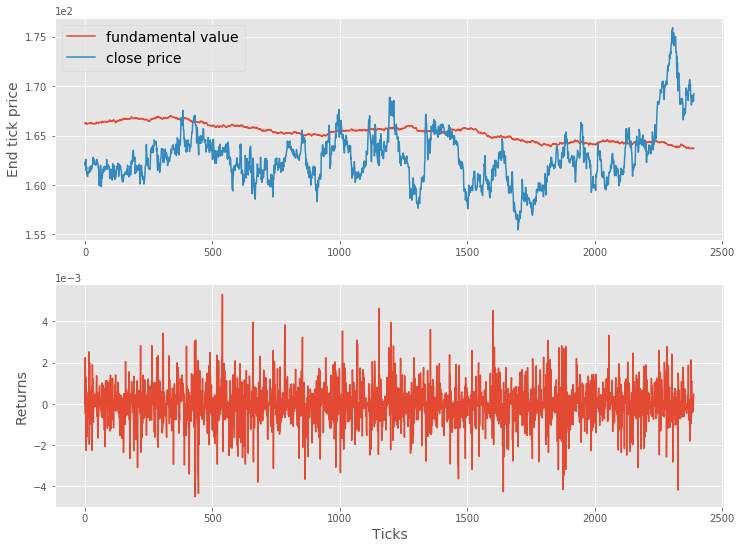

In [47]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,9))

ax1.plot(mc_fundamentals.index, mc_fundamentals.median(axis=1), label='fundamental value')
ax1.plot(mc_prices.index, mc_prices.median(axis=1), label='close price')

ax1.set_ylabel('End tick price', fontsize='14')
ax1.legend(loc='best', fontsize='14')

ax2.plot(mc_returns.index, mc_returns.median(axis=1))
ax2.set_ylabel('Returns', fontsize='14')
ax2.set_xlabel('Ticks', fontsize='14')

for ax in [ax1, ax2]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    
fig.savefig('model_dynamics.png')

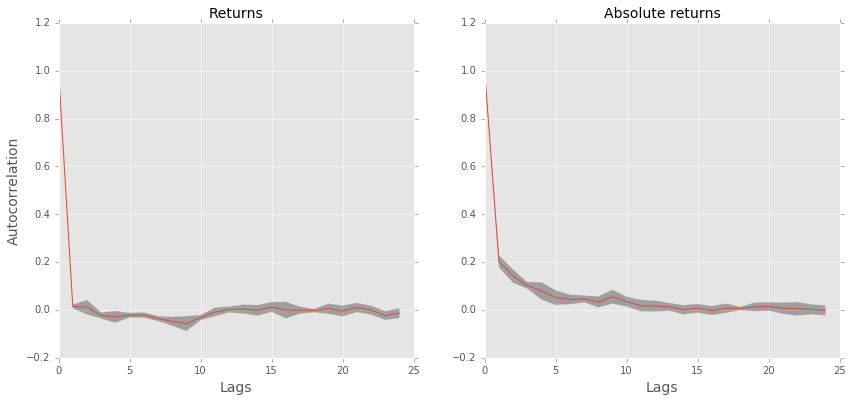

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))

lenght = 20

ax1.plot(mc_autocorr_returns.index, mc_autocorr_returns.mean(axis=1), label='Returns')
#ax1.plot(mc_autocorr_returns.index, autocorr_spy_returns, 'ko', label='SPY Returns')
ax1.fill_between(mc_autocorr_returns.index, 
                 mc_autocorr_returns.mean(axis=1)+mc_autocorr_returns.std(axis=1), 
                 mc_autocorr_returns.mean(axis=1)-mc_autocorr_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')
ax1.set_title('Returns', fontsize=14)

ax2.plot(mc_autocorr_abs_returns.index, mc_autocorr_abs_returns.mean(axis=1), label='Abs returns')
#ax2.plot(mc_autocorr_returns.index, autocorr_spy_abs_returns, 'ks', label='SPY Abs returns')
ax2.fill_between(mc_autocorr_abs_returns.index, 
                 mc_autocorr_abs_returns.mean(axis=1)+mc_autocorr_abs_returns.std(axis=1), 
                 mc_autocorr_abs_returns.mean(axis=1)-mc_autocorr_abs_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')
ax2.set_title('Absolute returns', fontsize=14)

#ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')

#ax2.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_xlabel('Lags', fontsize='14')
ax2.set_xlabel('Lags', fontsize='14')

fig.savefig('auto_correlation.png')

### Calculate fitness

In [8]:
def model_fitness(mc_rets, mc_p, mc_f, emp_m, weights):    
    first_order_autocors = []
    autocors1 = []
    autocors5 = []
    mean_abs_autocor = []
    kurtoses = []
    spy_abs_auto10 = []
    spy_abs_auto25 = []
    spy_abs_auto50 = []
    spy_abs_auto100 = []
    cointegrations = []
    for col in mc_rets:
        first_order_autocors.append(autocorrelation_returns(mc_rets[col][1:], 25))
        autocors1.append(mc_rets[col][1:].autocorr(lag=1))
        autocors5.append(mc_rets[col][1:].autocorr(lag=5))
        mean_abs_autocor.append(autocorrelation_abs_returns(mc_rets[col][1:], 25))
        kurtoses.append(mc_rets[col][2:].kurtosis())
        spy_abs_auto10.append(mc_rets[col][1:].abs().autocorr(lag=10))
        spy_abs_auto25.append(mc_rets[col][1:].abs().autocorr(lag=25))
        spy_abs_auto50.append(mc_rets[col][1:].abs().autocorr(lag=50))
        spy_abs_auto100.append(mc_rets[col][1:].abs().autocorr(lag=100))
        cointegrations.append(cointegr(mc_p[col][1:], mc_f[col][1:])[0])

    stylized_facts_sim = np.array([
        np.mean(first_order_autocors),
        np.mean(autocors1),
        np.mean(autocors5),
        np.mean(mean_abs_autocor),
        np.mean(kurtoses),
        np.mean(spy_abs_auto10),
        np.mean(spy_abs_auto25),
        np.mean(spy_abs_auto50),
        np.mean(spy_abs_auto100),
        np.mean(cointegrations)
    ])

    # return cost
    return quadratic_loss_function(stylized_facts_sim, emp_m, weights)

In [9]:
model_jscore = model_fitness(mc_returns, mc_prices, mc_fundamentals, empirical_moments, W)

# Run model without mean-reversion

In [10]:
traders_nmr = []
obs_nmr = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects(params_nmr, seed)
    traders, orderbook = sim_fin_model(traders, orderbook, params_nmr, seed)
    traders_nmr.append(traders)
    obs_nmr.append(orderbook)

In [11]:
mc_prices_nmr, mc_returns_nmr, mc_autocorr_returns_nmr, mc_autocorr_abs_returns_nmr, mc_volatility_nmr, mc_volume_nmr, mc_fundamentals_nmr = organise_data(obs_nmr)

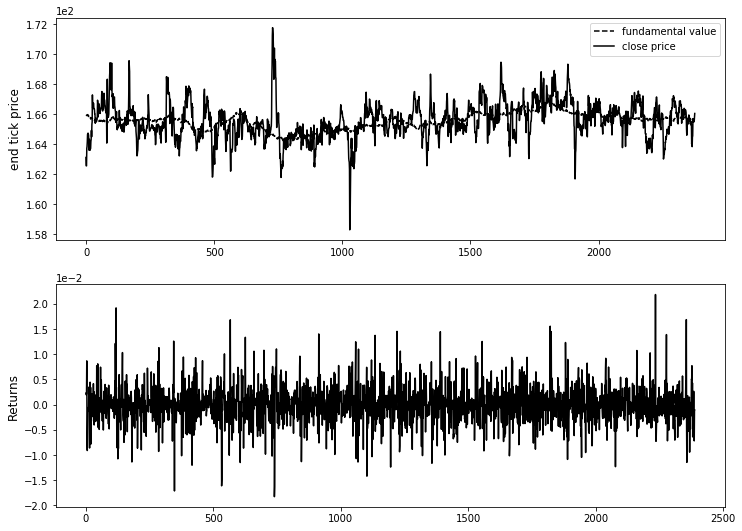

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,9))

ax1.plot(mc_fundamentals_nmr.index, mc_fundamentals_nmr.median(axis=1), 'k--', label='fundamental value')
ax1.plot(mc_prices_nmr.index, mc_prices_nmr.median(axis=1), 'k-', label='close price')

ax1.set_ylabel('end tick price', fontsize='12')
ax1.legend(loc='best')

ax2.plot(mc_returns.index, mc_returns.median(axis=1), 'k-')
ax2.set_ylabel('Returns', fontsize='12')


for ax in [ax1, ax2]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    
#fig.savefig('model_dynamics.png')

In [13]:
model_nmr_jscore = model_fitness(mc_returns_nmr, mc_prices_nmr, mc_fundamentals_nmr, empirical_moments, W)

# Quantitative model comparison

## 1 Model performance comparison via p-value
-	Apply the loss function to the bootstrapped data N=5000 series
-	This gives a distribution of J-values and the 95% confidence intervals
-	Simulate the model N-runs again with the same length as the data
-	Compare the distribution of J-values from this simulation with the distribution of J-values from the bootstrapped data.
-	The p-value of the model is the quantile at which the empirical J-95% interval lies. 
-	Hope that the p-value of the model > 10% 
-	The biggest p-value wins!! :D

In [14]:
bootstrapped_j_values = json.loads(open('bootstrapped_j_values.json').read())

In [15]:
# Get the t-critical value*
def confidence_interval(sample):
    """Calculate confidence_interval in sample"""
    z_critical = stats.norm.ppf(q = 0.97)
    mean = np.mean(sample)
    stdev = np.std(sample)
    margin_of_error = z_critical * stdev
    confidence_interval = (mean - margin_of_error, mean + margin_of_error)  
    return confidence_interval

Text(0.5,1,'j-values')

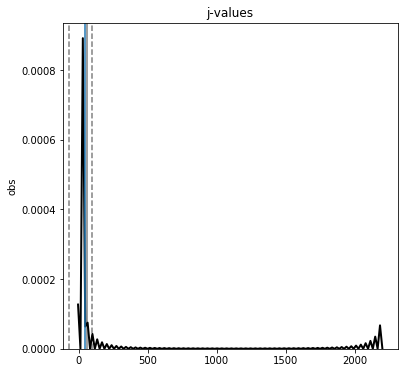

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

sns.distplot(bootstrapped_j_values, hist=False, kde=True, 
             bins=int(180/5), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax)

for xc in confidence_interval(bootstrapped_j_values):
    ax.axvline(x=xc, color='k', linestyle ='dashed', alpha=0.5)
    
ax.axvline(x=model_nmr_jscore, color='k', alpha=0.5)
ax.axvline(x=model_jscore)

ax.set_ylabel('obs')
ax.set_title('j-values')

Find the p value which gets you the quantile of the model.

In [17]:
def find_quantile(x, model_j):
    """Find the quantile of the bootstrapped J-value on the distribution of simulated J-values"""
    return model_j - pd.Series(bootstrapped_j_values).quantile(x)

min_x = 0.0
max_x = 1.0

In [18]:
p_val_model = 1 - scipy.optimize.brentq(find_quantile, min_x, max_x, args = (model_jscore))
p_val_model_nmr = 1 - scipy.optimize.brentq(find_quantile, min_x, max_x, args = (model_nmr_jscore))

In [19]:
print('p-value model = ', p_val_model)
print('p-value model nmr = ', p_val_model_nmr)

('p-value model = ', 0.0007169325485824052)
('p-value model nmr = ', 0.0003993408549627375)


In [20]:
if p_val_model > p_val_model_nmr:
    print('Model with mean reversion wins the first round')
else:
    print('Model without mean reversion wins the first round')

Model with mean reversion wins the first round


## 2 Model performance pairwise comparison

5000 simulations of each model with identical random seed

In [21]:
NRUNS_pairwise = 100

First run 5000 iterations of the model.

In [22]:
traders_p = []
obs_p = []
for seed in range(NRUNS_pairwise): 
    traders, orderbook = init_objects(params, seed)
    traders, orderbook = sim_fin_model(traders, orderbook, params, seed)
    traders_p.append(traders)
    obs_p.append(orderbook)

In [23]:
mc_prices_p, mc_returns_p, mc_autocorr_returns_p, mc_autocorr_abs_returns_p, mc_volatility_p, mc_volume_p, mc_fundamentals_p = organise_data(obs_p)

Then run 5000 iterations of the model without mean reversion

In [24]:
traders_nmr_p = []
obs_nmr_p = []
for seed in range(NRUNS_pairwise): 
    traders, orderbook = init_objects(params_nmr, seed)
    traders, orderbook = sim_fin_model(traders, orderbook, params_nmr, seed)
    traders_nmr_p.append(traders)
    obs_nmr_p.append(orderbook)

In [25]:
mc_prices_nmr_p, mc_returns_nmr_p, mc_autocorr_returns_nmr_p, mc_autocorr_abs_returns_nmr_p, mc_volatility_nmr_p, mc_volume_nmr_p, mc_fundamentals_nmr_p = organise_data(obs_nmr_p)

### 2.1 Compare loss function for each simulation Count how often the new model outperforms the old model

In [26]:
model_wins = 0
nmr_wins = 0
for col in mc_prices_p:
    loss_func_model = model_fitness(pd.DataFrame(mc_returns_p[col]), pd.DataFrame(mc_prices_p[col]), 
                                    pd.DataFrame(mc_fundamentals_p[col]), empirical_moments, W)
    loss_func_model_nmr = model_fitness(pd.DataFrame(mc_returns_nmr_p[col]), pd.DataFrame(mc_prices_nmr_p[col]), 
                                        pd.DataFrame(mc_fundamentals_nmr_p[col]), empirical_moments, W)
    if loss_func_model < loss_func_model_nmr:
        model_wins += 1
    if loss_func_model > loss_func_model_nmr:
        nmr_wins += 1
#model_fitness(mc_rets, mc_p, mc_f, emp_m, weights)

In [27]:
print('the model wins ', model_wins, 'times')
print('the nmr model wins ', nmr_wins, 'times')
print('The model / model_nmr score is: ', model_wins/ float(nmr_wins + model_wins))

('the model wins ', 67, 'times')
('the nmr model wins ', 33, 'times')
('The model / model_nmr score is: ', 0.67)


### 2.2	Pool simulations. 

Divide the j-scores of both models into non-overlapping samples of size 10 and for each calculate the average value for each sample. Count how often the sample of model1 outperforms the sample of model 2.

In [28]:
chunk_size = 10

In [29]:
# first make list of all j-scores
j_scores_model = []
j_scores_nmr = []
for col in mc_prices_p:
    j_scores_model.append(model_fitness(pd.DataFrame(mc_returns_p[col]), pd.DataFrame(mc_prices_p[col]), 
                                    pd.DataFrame(mc_fundamentals_p[col]), empirical_moments, W))
    j_scores_nmr.append(model_fitness(pd.DataFrame(mc_returns_nmr_p[col]), pd.DataFrame(mc_prices_nmr_p[col]), 
                                        pd.DataFrame(mc_fundamentals_nmr_p[col]), empirical_moments, W))

In [30]:
def sample_list(l, n):
    """returns a list (l) of chunks size n"""
    return [l[i:i + n] for i in xrange(0, len(l), n)]

In [31]:
sampled_j_scores_model = sample_list(j_scores_model, chunk_size)
sampled_j_scores_nmr = sample_list(j_scores_nmr, chunk_size)

In [32]:
sampled_model_wins = 0
sampled_nmr_wins = 0
for idx in range(10):
    score = np.mean(sampled_j_scores_model[idx]) - np.mean(sampled_j_scores_nmr[idx])
    if score > 0:
        sampled_model_wins += 1
    if score < 0:
        sampled_nmr_wins += 1

In [33]:
print('the model wins ', sampled_model_wins, 'times')
print('the nmr model wins ', sampled_nmr_wins, 'times')
print('The model / model_nmr score is: ', sampled_model_wins/ float(sampled_nmr_wins + sampled_model_wins))

('the model wins ', 5, 'times')
('the nmr model wins ', 5, 'times')
('The model / model_nmr score is: ', 0.5)


## 3 Model comparison via moment coverage ratio:

-	Find confidence interval for all moments: = +1.96 * standard error around empirical estimate
-	Count the number of simulations for which the single moments (or all moments jointly) are contained in their confidence intervals. 
-	Calculate joint moments coverage ratio for bootstrapped samples. This can be used as a yardstick to compare model performance.  


In [34]:
confidence_intervals_moments = json.loads(open('bootstrapped_confidence_intervals.json').read())

In [35]:
# check if all moments are within the intervals
def between_interval(interval, value):
    if interval[0] <= value <= interval[1]:
        return True
    else:
        return False

In [36]:
def get_model_moments_in_confidence(mc_rets, mc_p, mc_f, conf_int_mom):
    """Get moments of a particular simulation and check if they fall in the bounds"""
    first_order_autocors = []
    autocors1 = []
    autocors5 = []
    mean_abs_autocor = []
    kurtoses = []
    spy_abs_auto10 = []
    spy_abs_auto25 = []
    spy_abs_auto50 = []
    spy_abs_auto100 = []
    cointegrations = []
    for col in mc_rets:
        first_order_autocors.append(autocorrelation_returns(mc_rets[col][1:], 25))
        autocors1.append(mc_rets[col][1:].autocorr(lag=1))
        autocors5.append(mc_rets[col][1:].autocorr(lag=5))
        mean_abs_autocor.append(autocorrelation_abs_returns(mc_rets[col][1:], 25))
        kurtoses.append(mc_rets[col][2:].kurtosis())
        spy_abs_auto10.append(mc_rets[col][1:].abs().autocorr(lag=10))
        spy_abs_auto25.append(mc_rets[col][1:].abs().autocorr(lag=25))
        spy_abs_auto50.append(mc_rets[col][1:].abs().autocorr(lag=50))
        spy_abs_auto100.append(mc_rets[col][1:].abs().autocorr(lag=100))
        cointegrations.append(cointegr(mc_p[col][1:], mc_f[col][1:])[0])

    moments = np.array([
        np.mean(first_order_autocors),
        np.mean(autocors1),
        np.mean(autocors5),
        np.mean(mean_abs_autocor),
        np.mean(kurtoses),
        np.mean(spy_abs_auto10),
        np.mean(spy_abs_auto25),
        np.mean(spy_abs_auto50),
        np.mean(spy_abs_auto100),
        np.mean(cointegrations)])
    
    
    mom_covered = [between_interval(i, v) for i,v in zip(conf_int_mom, moments)]
    return mom_covered

In [47]:
confidence_intervals_moments

[[-0.014802207859241683, -0.00381338520933001],
 [-0.17714150893809588, -0.01629520926335798],
 [-0.10710049157252854, -0.009325021616514169],
 [0.1137168668465085, 0.5523703361520312],
 [2.9701436761197613, 21.711207883598597],
 [0.17229439736020258, 0.519916247879216],
 [0.08496455990583895, 0.44702201878227654],
 [0.053555935975001995, 0.3208388369069016],
 [0.05664312062039355, 0.29721186902444285],
 [-7.092498758498019, 0.3006026469341081]]

In [37]:
mcr_scores_model = []
mcr_scores_nmr = []
for col in mc_prices_p:
    mcr_scores_model.append(get_model_moments_in_confidence(pd.DataFrame(mc_returns_p[col]), pd.DataFrame(mc_prices_p[col]), 
                                    pd.DataFrame(mc_fundamentals_p[col]), confidence_intervals_moments))
    mcr_scores_nmr.append(get_model_moments_in_confidence(pd.DataFrame(mc_returns_nmr_p[col]), pd.DataFrame(mc_prices_nmr_p[col]), 
                                        pd.DataFrame(mc_fundamentals_nmr_p[col]), confidence_intervals_moments))

For every moment: count the number of simulations for which the single moments (or all moments jointly) are contained in their confidence intervals. 

In [38]:
def true_scores(simulations, m_index):
    """
    For every moment: count the number of simulations for which the single moments (or all moments jointly) are contained in their confidence intervals.
    """
    score = 0
    for s in simulations:
        if s[m_index]:
            score += 1
    return (float(score) / len(simulations)) * 100

In [39]:
def joint_mcr(simulations):
    """Calculate joint moments coverage ratio"""
    score = 0
    for s in simulations:
        if False not in s:
            score += 1
    return (float(score) / len(simulations)) * 100

In [40]:
moment_scores_model = [true_scores(mcr_scores_model, i) for i in range(len(empirical_moments))]
moment_scores_nmr = [true_scores(mcr_scores_nmr, i) for i in range(len(empirical_moments))]

In [41]:
bootstrapped_moments = json.loads(open('all_bootstrapped_moments.json').read())

In [42]:
# bootstrapped_moments = list of all moments per stylized fact 
# transform to list of simulations with all moments
b_moments = []
for idx in range(len(bootstrapped_moments[0])):
    this_sims_moments = []
    for all_moments in bootstrapped_moments:
        relevant_moment = all_moments[idx]
        this_sims_moments.append(relevant_moment)
    b_moments.append(this_sims_moments)

In [43]:
moment_bootstr = [true_scores(b_moments, i) for i in range(len(empirical_moments))]

In [44]:
b_moments_scores = []
for b_sim in b_moments:
    b_moments_scores.append([between_interval(i, v) for i,v in zip(confidence_intervals_moments, b_sim)])

In [45]:
moment_scores_b = [true_scores(b_moments_scores, i) for i in range(len(empirical_moments))]

## Produce table of moments coverage for all models

In [46]:
mcr = {'joint_mcr': {'emp': joint_mcr(b_moments_scores), 'model': joint_mcr(mcr_scores_model), 'nmr':joint_mcr(mcr_scores_nmr)},
       'jmcr_pcnt': {'emp': np.nan, 'model': joint_mcr(mcr_scores_model)/ joint_mcr(b_moments_scores), 'nmr':joint_mcr(mcr_scores_nmr)/joint_mcr(b_moments_scores)},
       'no_autocor': {'emp': moment_scores_b[0], 'model': moment_scores_model[0], 'nmr':moment_scores_nmr[0]},
      'autocor1': {'emp': moment_scores_b[1], 'model': moment_scores_model[1], 'nmr':moment_scores_nmr[1]},
      'autocor5': {'emp': moment_scores_b[2], 'model': moment_scores_model[2], 'nmr':moment_scores_nmr[2]},
      'mean_abs_autocor': {'emp': moment_scores_b[3], 'model': moment_scores_model[3], 'nmr':moment_scores_nmr[3]},
      'kurtosis': {'emp': moment_scores_b[4], 'model': moment_scores_model[4], 'nmr':moment_scores_nmr[4]},
      'abs_auto10': {'emp': moment_scores_b[5], 'model': moment_scores_model[5], 'nmr':moment_scores_nmr[5]},
      'abs_auto25': {'emp': moment_scores_b[6], 'model': moment_scores_model[6], 'nmr':moment_scores_nmr[6]},
      'abs_auto50': {'emp': moment_scores_b[7], 'model': moment_scores_model[7], 'nmr':moment_scores_nmr[7]},
      'abs_auto100': {'emp': moment_scores_b[8], 'model': moment_scores_model[8], 'nmr':moment_scores_nmr[8]},
      'cointegration': {'emp': moment_scores_b[9], 'model': moment_scores_model[9], 'nmr':moment_scores_nmr[9]}}
df = pd.DataFrame(mcr, columns=mcr.keys())#.transpose()
cols = ['joint_mcr', 'jmcr_pcnt','no_autocor', 'autocor1', 'autocor5', 'mean_abs_autocor', 'kurtosis', 
        'abs_auto10', 'abs_auto25', 'abs_auto50', 'abs_auto100', 'cointegration']
df = df[cols].transpose()
df

,emp,model,nmr
joint_mcr,57.36,0.0,0.0
jmcr_pcnt,NaN,0.0,0.0
no_autocor,95.06,94.0,98.0
autocor1,95.08,41.0,94.0
autocor5,95.78,78.0,74.0
mean_abs_autocor,94.64,0.0,0.0
kurtosis,91.76,92.0,94.0
abs_auto10,91.52,0.0,0.0
abs_auto25,90.22,0.0,1.0
abs_auto50,86.60,4.0,1.0
